In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from skimage import io, color, transform, feature, filters
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using BinaryClassificationPerformance v1.03


In [2]:
# help(BinaryClassificationPerformance)

### file paths and names

In [3]:
ci_path = '/Users/meeraramesh/Desktop/School/git/ml/final_assignment_2/plane_data/cropped_images/'
l_file = '/Users/meeraramesh/Desktop/School/git/ml/final_assignment_2/plane_data/plane_labels.csv'

# Function for feature building and extraction on photographs¶

scikit-image documentation on methods used for feature extraction:  

* http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray  
* http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize  
* http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

In [4]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
dims = (15, 35) # 25% of the original size, 525 pixels

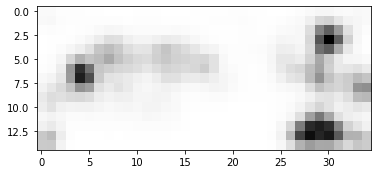

downscaled image shape: 
(15, 35)
image representation (first row of pixels): 
[0.03595872 0.03672943 0.01629895 0.01279022 0.01254651 0.00897317
 0.00523036 0.00277105 0.0025309  0.00349334 0.00502946 0.00652903
 0.0062032  0.00346726 0.00199169 0.00260336 0.00416323 0.00709959
 0.00751603 0.00737113 0.01142706 0.01309353 0.00919321 0.00459549
 0.00226189 0.00313457 0.00847177 0.01947856 0.04009014 0.06964681
 0.06974397 0.04294428 0.03509388 0.04756239 0.04235021]


example of transformation: 


In [5]:
def image_manipulation(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png'
    img_raw = io.imread(imname, as_gray=True)
    downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
    final_image = filters.hessian(downscaled) # hessian filter that "can be used to detect continuous edges"
    final_image = feature.canny(final_image) # edge filter image with Canny algorithm
    final_image = feature.corner_harris(downscaled, 2, 4, 0.04) # reduce to just corner features, change from 3 to 4 
    
    if imview==True:
        plt.figure()
        plt.imshow(final_image, cmap='Greys')
        plt.show()
    warnings.filterwarnings('always')
    return final_image

# test the function, look at input/output
# me: changed to matplotlib bc io.imshow doesn't work
test_image = image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

for comparison, look at original image:

# function to process raw images, resulting in training and test datasets

In [6]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        new_img = image_manipulation(row['img_name'], images_fp)
        features_list.append(new_img)
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name']) 
   
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)


In [7]:
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=13, imview=False, test=False)

First few lines of image labels: 
                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
Size of image label dataFrame: 
(6758, 2)
Shape of original feature representation: 
(6758, 15, 35)
Shape of flat feature representation: 
(6758, 525)
Shape of Y: 
(6758,)
Number of images with planes: 
101
Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
80
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
21
Shape of data_train and data_test:
(5068, 525)
(1690, 525)
Shape of y_train and y_test:
(5068,)
(1690,)
Shape of imgs_train and imgs_test:
(5068,)
(1690,)
SUCCESS!


# train Multilayer Perceptron, a.k.a. neural network

In [8]:
from sklearn import neural_network
nn8 = neural_network.MLPClassifier(hidden_layer_sizes = (100,100,100,100,100,100,100,100,100,100,100,100,50), alpha = .0003, max_iter=10000000000000)
print(nn8)
nn8.fit(data_train, y_train)

nn8_performance = BinaryClassificationPerformance(nn8.predict(data_train), y_train, 'nn8')
nn8_performance.compute_measures()
nn8_performance.performance_measures['set'] = 'train'
print('TRAINING SET 8: ')
print(nn8_performance.performance_measures)

nn8_performance_test = BinaryClassificationPerformance(nn8.predict(data_test), y_test, 'nn8')
nn8_performance_test.compute_measures()
nn8_performance_test.performance_measures['set'] = 'test'
print('TEST SET 8: ')
print(nn8_performance_test.performance_measures)

nn8_performance_test.img_indices()
nn8_img_indices_to_view = nn8_performance_test.image_indices

MLPClassifier(alpha=0.0003,
              hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100,
                                  100, 100, 100, 50),
              max_iter=10000000000000)
TRAINING SET 8: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn8', 'set': 'train'}
TEST SET 8: 
{'Pos': 21, 'Neg': 1669, 'TP': 18, 'TN': 1667, 'FP': 2, 'FN': 3, 'Accuracy': 0.9970414201183432, 'Precision': 0.9, 'Recall': 0.8571428571428571, 'desc': 'nn8', 'set': 'test'}


# look at examples of neural network classifications

## true positives

In [9]:
# performance_examples('TP', nn_img_indices_to_view)

## false positives

In [10]:
# performance_examples('FP', nn_img_indices_to_view)

## false negatives

In [11]:
# performance_examples('FN', nn_img_indices_to_view)

# SUBMISSION

### file paths and names:

In [12]:
submission_ci_path = '/Users/meeraramesh/Desktop/School/git/ml/final_assignment_2/test_data_for_grading/test_cropped_images/' # file path for cropped images for training
submission_l_file = '/Users/meeraramesh/Desktop/School/git/ml/final_assignment_2/test_data_for_grading/test_plane_labels.csv' # file path and file name for csv with labels

In [13]:
X_test_data, X_test_submission = process_raw_data(submission_l_file, submission_ci_path, my_random_seed=13, test=True)
print("Number of rows in the submission test set (should be 1,523): ")

First few lines of image labels: 
                   img_name
0  2016-08-02T13+50+24_430Z
1  2016-08-02T14+12+37_390Z
2  2016-08-03T12+32+21_790Z
3  2016-08-03T13+19+28_320Z
4  2016-08-05T15+24+58_670Z
Size of image label dataFrame: 
(1523, 1)
Shape of original feature representation: 
(1523, 15, 35)
Shape of flat feature representation: 
(1523, 525)
Shape of X_test for submission:
(1523, 525)
SUCCESS!
Number of rows in the submission test set (should be 1,523): 


### IMPORTANT CHECK: make sure that the number of columns in your training data is the same as the number of columns in this test submission!

In [14]:
print(data_train.shape)
print(X_test_data.shape)

(5068, 525)
(1523, 525)


Both the training set and submission test set have 525 columns. Success!

---

Choose a *single* model for your submission. In this code, I am choosing the Perceptron model fit, which is in the prc object. But you should choose the model that is performing the best for you!

In [15]:
# concatenate predictions to the id
X_test_submission["prediction"] = nn8.predict(X_test_data) #neural net w/ hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100, 100)
# look at the proportion of positive predictions
print(X_test_submission['prediction'].mean())

0.014445173998686802


This is the proportion of predictions that have predicted that there is an airplane in the image.

In [16]:
print(X_test_submission.shape) # should be (1523, 2)

(1523, 2)


In [17]:
# export submission file as pdf
# CHANGE FILE PATH: 
X_test_submission.to_csv('/Users/meeraramesh/Desktop/airplane_submission2.csv', index=False)

submission 1 performance

In [18]:
{'Pos': 23, 'Neg': 1500, 'TP': 18, 'TN': 1495, 'FP': 5, 'FN': 5, 'pos': 0.015101772816808929, 'neg': 0.9848982271831911, 'clr': 0.015333333333333332, 'acc': 0.9934340118187788, 'err': 0.006565988181221227, 'tpr': 0.782608695652174, 'tnr': 0.9966666666666667, 'fpr': 0.0033333333333333335, 'fnr': 0.21739130434782608, 'prec': 0.782608695652174, 'name': '1_meera'}, 

({'Pos': 23,
  'Neg': 1500,
  'TP': 18,
  'TN': 1495,
  'FP': 5,
  'FN': 5,
  'pos': 0.015101772816808929,
  'neg': 0.9848982271831911,
  'clr': 0.015333333333333332,
  'acc': 0.9934340118187788,
  'err': 0.006565988181221227,
  'tpr': 0.782608695652174,
  'tnr': 0.9966666666666667,
  'fpr': 0.0033333333333333335,
  'fnr': 0.21739130434782608,
  'prec': 0.782608695652174,
  'name': '1_meera'},)